In [29]:
from __future__ import unicode_literals
import os, sys
import numpy as np
import pickle as pk
import meshio as msh
import time
import compaction as cpt

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [196]:
## Import VTK file from DARTS run 
def getvtkData(filename):
    """
    This function uploads coordinates, and pressure field 
    """
    data = msh.read(filename)
    
    # Here the nodes coordinates
    # coordinates 3 lines, Nnodes columns
    points = data.points.T
    
    nodes = np.zeros((3,len(points[0][:])))
    for k in range(len(points[0][:])):
        nodes[0][k] = points[1][k]
        nodes[1][k] = points[0][k]
        nodes[2][k] = points[2][k]
    
    print('Nodes shape',nodes.shape)
    
    #x-nodes: nodes[1][:]
    #y-nodes: nodes[0][:]
    #z-nodes: nodes[2][:]
    
    # Upload the connectivity of the mesh
    # prisms Nelem lines, 8 columns (nodes per elem) =data.cells_dict['hexahedron'].shape[1]
    print(data.cells)
    connectivity = data.cells_dict['hexahedron']
    
    print(connectivity[0])
    print(connectivity.shape)
    
    elem_coords = np.zeros((len(connectivity),6))
    
    for k in range(len(connectivity)):
        prism = connectivity[k]
        xloc , yloc , zloc = [] , [] , []
        for i in prism:
            yloc.append(nodes[0][i])
            xloc.append(nodes[1][i])
            zloc.append(nodes[2][i])
        elem_coords[k][0] = np.amin(yloc)
        elem_coords[k][1] = np.amax(yloc)
        
        elem_coords[k][2] = np.amin(xloc)
        elem_coords[k][3] = np.amax(xloc)

        elem_coords[k][4] = np.amax(zloc)
        elem_coords[k][5] = np.amin(zloc)
    
    print('elems',elem_coords.shape)

    # Upload pressure but change the nan for -1
    # pressure Nelem lines
    ptest = data.cell_data['pressure']
    
    p = np.zeros(len(ptest[0]))
    for k in range(len(p)):
        if(np.isnan(ptest[0][k])):
            p[k] = 0
        else:
            p[k] = 40 - ptest[0][k]*0.1 #convert pressure from bar (DARTS) to MPa (to use in compaction) - original Pressure in DARTS = 40 Mpa

    return nodes, elem_coords, p

Use compaction code to calculate both displacements and stresses on all the cells of the mesh using the source of strain concept

In [197]:
#Calculating oneway mechanical results for the reservoir domain

time_0 = time.process_time() # Here start count time
    
# Load the data from the vtk file

# Make a loop for time (pressure = p - p_init)

coordinates, prisms, pressure = getvtkData('data/vtk_data/data_ts0.vtk')

# Define elastic constants
poisson = 0.25
young   = 3300.

# Now we solve the reservoir's displacement
ux = cpt.displacement_x_component(coordinates, prisms, pressure, poisson, young)
uy = cpt.displacement_y_component(coordinates, prisms, pressure, poisson, young)
uz = cpt.displacement_z_component(coordinates, prisms, pressure, poisson, young)

# Now we solve the reservoir's stress state
sx = cpt.stress_x_component(coordinates, prisms, pressure, poisson, young)
sy = cpt.stress_y_component(coordinates, prisms, pressure, poisson, young)
sz = cpt.stress_z_component(coordinates, prisms, pressure, poisson, young)


#Calculating oneway mechanical results for the surface layer 

surface_layer = np.zeros((3,coordinates.shape[1]))
#merge coordinates[0:2,:] in surface_layer
surface_layer[0:2,:] = coordinates[0:2,:]


# Now we solve the surface's displacement
surface_ux = cpt.displacement_x_component(surface_layer, prisms, pressure, poisson, young)
surface_uy = cpt.displacement_y_component(surface_layer, prisms, pressure, poisson, young)
surface_uz = cpt.displacement_z_component(surface_layer, prisms, pressure, poisson, young)


time_1 = time.process_time() # Here end counting time



print("Elapsed time to plot: %0.3f mins." % ((time_1-time_0)/60.0))

    

Nodes shape (3, 7442)
[<meshio CellBlock, type: hexahedron, num cells: 3600, tags: []>]
[   0    1   62   61 3721 3722 3783 3782]
(3600, 8)
elems (3600, 6)
Elapsed time to plot: 1.823 mins.


Plot the results

In [200]:
#Reference lines to plot the results
top_layer = coordinates[2][:] == -4000  
midle_line_y =  coordinates[0][:] == np.average(coordinates[0][:])
midle_line_x =  coordinates[1][:] == np.average(coordinates[1][:])
top_midle_line_x = np.logical_and(top_layer, midle_line)

uz_top_midle_line_x  = uz[top_midle_line_x]
surface_uz_top_midle_line_x  = surface_uz[top_midle_line_x]


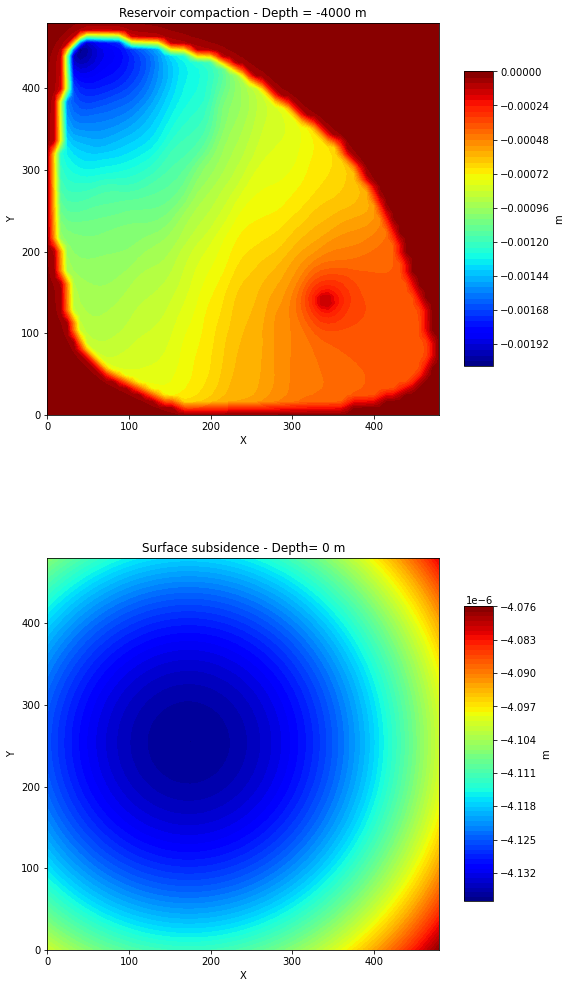

In [300]:
shape = (61,61) #just the shape of the plot sqrt(3721 - total points )
east_min = np.amin(coordinates[1][top_layer])
east_max = np.amax(coordinates[1][top_layer])
west_min = np.amin(coordinates[0][top_layer])
west_max = np.amax(coordinates[0][top_layer])
np.linspace(east_min, east_max, shape[0])
x=np.linspace(east_min, east_max, shape[0]) 
y=np.linspace(west_min, west_max, shape[1]) 
z=uz[top_layer].reshape(shape)

# Plot the displacement fields 
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(8,15))

ax[0].set_aspect("equal")
img = ax[0].contourf(y, x, z, 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[0], aspect=10, pad=0.05, shrink=0.6)
cb.set_label('m', rotation=90, fontsize=10)
ax[0].set_title("Reservoir compaction - Depth = -4000 m")
ax[0].set_xlabel("X")
ax[0].set_ylabel("Y")

z=surface_uz[top_layer].reshape(shape)
ax[1].set_aspect("equal")
img = ax[1].contourf(y, x, z, 
                  60, cmap="jet")
cb = plt.colorbar(img, ax=ax[1],aspect=10, pad=0.05, shrink=0.6)
cb.set_label('m', rotation=90, fontsize=10)
ax[1].set_title("Surface subsidence - Depth= 0 m")
ax[1].set_xlabel("X")
ax[1].set_ylabel("Y")
plt.tight_layout(True)



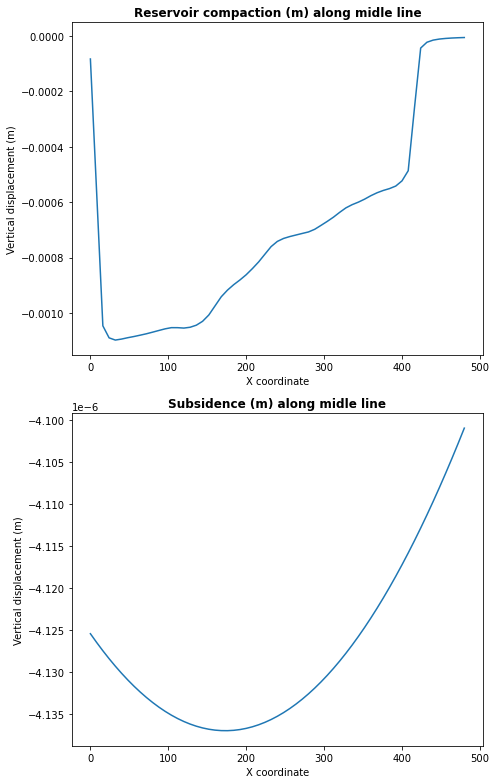

In [299]:
fig2, axs = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(7,11))
#line plot of top_midle_line_uz agains top_midle coordinates colors representing uz_top_midle_line_x

img = axs[0].plot(coordinates[1][top_midle_line_x],uz_top_midle_line_x)
axs[0].set_title('Reservoir compaction (m) along midle line', fontweight ="bold")
axs[0].set_xlabel("X coordinate")
axs[0].set_ylabel("Vertical displacement (m)")

img = axs[1].plot(coordinates[1][top_midle_line_x],surface_uz_top_midle_line_x)
axs[1].set_title('Subsidence (m) along midle line', fontweight ="bold")
axs[1].set_xlabel("X coordinate")
axs[1].set_ylabel("Vertical displacement (m)")

fig2.tight_layout()
plt.show()

